# Exploring all data from a tissue in the Cell Census

The Cell Census is a versioned container for the single-cell data hosted at [CELLxGENE Discover](https://cellxgene.cziscience.com/). The Cell Census utilizes [SOMA](https://github.com/single-cell-data/SOMA/blob/main/abstract_specification.md) powered by [TileDB](https://tiledb.com/products/tiledb-embedded) for storing, accessing, and efficiently filtering data.

This notebook shows you how to learn about the Cell Census contents and how to query it.

This notebook provides a demonstration for:

1. Learning about the lung data.
   1. Learning about cells of lung data.
   1. Larning about genes of lung data.
1. Fetching all human lung data from the Cell Census.
1. Obtaining QC metrics for this data slice.

## Learning about the lung data in the Cell Census

First we open the Cell Census, if you are not familiar with the basics of Cell Census API you should take a look at notebook "Learning about the CELLxGENE Cell Census" at `comp_bio_census_info.ipynb`.


In [1]:
import cell_census
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

Let's first take a look at the number of cells from human lung:


In [2]:
with cell_census.open_soma() as census:
    summary_table = census["census_info"]["summary_cell_counts"].read().concat().to_pandas()

summary_table.query("organism == 'Homo sapiens' & category == 'tissue_general' & label =='lung'")

,soma_joinid,organism,category,ontology_term_id,unique_cell_count,total_cell_count,label
889,889,Homo sapiens,tissue_general,UBERON:0002048,2131015,4408990,lung


There you can see the total of cells of under `total_cell_count` and the unique number cells under `unique_cell_count` (i.e. after removing cells that were included in multiple datasets).

Let's now take a look at the cell and gene information of this slice of the Cell Census.

### Learning about cells of lung data

Let's load the cell metadata for all lung cells and select only the unique cells using `is_primary_data`.


In [3]:
with cell_census.open_soma() as census:
    lung_obs = (
        census["census_data"]["homo_sapiens"]
        .obs.read(value_filter="tissue_general == 'lung' and is_primary_data == True")
        .concat()
        .to_pandas()
    )
lung_obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,is_primary_data,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id
0,68036,1e5bd3b8-6a0e-4959-8d69-cafed30fe814,10x 3' v3,EFO:0009922,T cell,CL:0000084,63-year-old human stage,HsapDv:0000157,normal,PATO:0000461,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,alveolus of lung,UBERON:0002299,lung,UBERON:0002048
1,68037,1e5bd3b8-6a0e-4959-8d69-cafed30fe814,10x 3' v3,EFO:0009922,T cell,CL:0000084,63-year-old human stage,HsapDv:0000157,normal,PATO:0000461,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,alveolus of lung,UBERON:0002299,lung,UBERON:0002048
2,68038,1e5bd3b8-6a0e-4959-8d69-cafed30fe814,10x 3' v3,EFO:0009922,monocyte,CL:0000576,63-year-old human stage,HsapDv:0000157,normal,PATO:0000461,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,alveolus of lung,UBERON:0002299,lung,UBERON:0002048
3,68039,1e5bd3b8-6a0e-4959-8d69-cafed30fe814,10x 3' v3,EFO:0009922,T cell,CL:0000084,63-year-old human stage,HsapDv:0000157,normal,PATO:0000461,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,alveolus of lung,UBERON:0002299,lung,UBERON:0002048
4,68040,1e5bd3b8-6a0e-4959-8d69-cafed30fe814,10x 3' v3,EFO:0009922,monocyte,CL:0000576,63-year-old human stage,HsapDv:0000157,normal,PATO:0000461,...,True,European,HANCESTRO:0005,male,PATO:0000384,cell,alveolus of lung,UBERON:0002299,lung,UBERON:0002048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131010,35371587,810ac45f-8969-4698-b42c-652f802f75c2,10x 5' v1,EFO:0011025,reticulocyte,CL:0000558,unknown,unknown,normal,PATO:0000461,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
2131011,35371628,810ac45f-8969-4698-b42c-652f802f75c2,10x 5' v1,EFO:0011025,reticulocyte,CL:0000558,unknown,unknown,normal,PATO:0000461,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
2131012,35371688,810ac45f-8969-4698-b42c-652f802f75c2,10x 5' v1,EFO:0011025,erythrocyte,CL:0000232,unknown,unknown,normal,PATO:0000461,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048
2131013,35371690,810ac45f-8969-4698-b42c-652f802f75c2,10x 5' v1,EFO:0011025,reticulocyte,CL:0000558,unknown,unknown,normal,PATO:0000461,...,True,unknown,unknown,unknown,unknown,cell,lung,UBERON:0002048,lung,UBERON:0002048


You can see that the number or rows represents the total number of unique lung cells in the Cell Census. Now let's take a deeper dive into the characteristics of these cells.

#### Datasets

First let's start by looking at what are the datasets and collections from [CELLxGENE Discover](https://cellxgene.cziscience.com/collections) contributing to lung. For this we will use the dataset table at `census["census-info"]["datasets"]` that contains metadata of all datasets used to build this Cell Census.


In [4]:
with cell_census.open_soma() as census:
    census_datasets = (
        census["census_info"]["datasets"]
        .read(column_names=["collection_name", "dataset_title", "dataset_id", "soma_joinid"])
        .concat()
        .to_pandas()
    )
census_datasets = census_datasets.set_index("dataset_id")
census_datasets

,collection_name,dataset_title,soma_joinid
dataset_id,,,
f512b8b6-369d-4a85-a695-116e0806857f,Transcriptional Programming of Normal and Infl...,Skin,0
1e5bd3b8-6a0e-4959-8d69-cafed30fe814,Emphysema Cell Atlas,immune cells,1
214bf9eb-93db-48c8-8e3c-9bb22fa3bc63,Emphysema Cell Atlas,AT2 cells,2
4b6af54a-4a21-46e0-bc8d-673c0561a836,Emphysema Cell Atlas,non-immune cells,3
fa8605cf-f27e-44af-ac2a-476bee4410d3,Acute COVID-19 cohort across a range of WHO ca...,PBMCs,4
...,...,...,...
cd4c96bb-ad66-4e83-ba9e-a7df8790eb12,Single-cell proteo-genomic reference maps of t...,3 healthy young and 3 healthy old bone marrow ...,473
c05fb583-eb2f-4e3a-8e74-f9bd6414e418,Single-cell proteo-genomic reference maps of t...,healthy young bone marrow donor,474
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890c,A transcriptomic atlas of the mouse cerebellum...,A transcriptomic atlas of the mouse cerebellum,475


The `obs` cell metadata `pandas.DataFrame` contains a column `dataset_id` that can be used for joining to the `census_dataset` `pandas.DataFrame` we just created.

So let's take a look at the cell counts per `dataset_id` of the lung slice and then join to the dataset table to append the human-readable labels.


In [5]:
dataset_cell_counts = pd.DataFrame(lung_obs[["dataset_id"]].value_counts())
dataset_cell_counts = dataset_cell_counts.rename(columns={0: "cell_counts"})
dataset_cell_counts = dataset_cell_counts.merge(census_datasets, on="dataset_id")

dataset_cell_counts

,cell_counts,collection_name,dataset_title,soma_joinid
dataset_id,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,107
066943a2-fdac-4b29-b348-40cede398e4e,254931,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,94
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,16
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,303
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,315
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",168
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,74
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,95
3de0ad6d-4378-4f62-b37b-ec0b75a50d94,46500,LungMAP — Human data from a broad age healthy ...,Single-cell multiomic profiling of human lungs...,55


These are all the datasets lung cells whose counts are reprensented in the column `cell_counts`. The top collections with lung data are:

1. [The integrated Human Lung Cell Atlas](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293).
2. [A human cell atlas of fetal gene expression](https://cellxgene.cziscience.com/collections/c114c20f-1ef4-49a5-9c2e-d965787fb90c).
3. [High-resolution single-cell atlas reveals diversity and plasticity of tumor-associated neutrophils in non-small cell lung cancer](https://cellxgene.cziscience.com/collections/edb893ee-4066-4128-9aec-5eb2b03f8287).
4. [HTAN MSK - Single cell profiling reveals novel tumor and myeloid subpopulations in small cell lung cancer](https://cellxgene.cziscience.com/collections/62e8f058-9c37-48bc-9200-e767f318a8ec).
5. [A human fetal lung cell atlas uncovers proximal-distal gradients of differentiation and key regulators of epithelial fates.](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028).

#### Assays

Let's use similar logic to take a look at all the assays available for human lung data. This tells us that most assays are from 10x technologies and sci-RNA-seq.


In [6]:
lung_obs[["assay"]].value_counts()

assay                                   
10x 3' v2                                   1039302
10x 3' v3                                    319978
10x 5' v1                                    218556
sci-RNA-seq                                  217738
BD Rhapsody Whole Transcriptome Analysis     122902
single cell library construction              58981
10x 5' v2                                     45798
microwell-seq                                 33698
Smart-seq2                                    25662
inDrop                                        25652
10x 3' v1                                     11558
Drop-seq                                       7333
10x 3' transcription profiling                 3857
dtype: int64

#### Disease

And now let's take a look at diseased cell counts, with `normal` indicating non-diseased cells.


In [7]:
lung_obs[["disease"]].value_counts()

disease                              
normal                                   1026980
lung adenocarcinoma                       626322
squamous cell lung carcinoma              189044
non-small cell lung carcinoma             120796
chronic obstructive pulmonary disease      55254
COVID-19                                   49014
pulmonary emphysema                        32065
small cell lung carcinoma                  31540
dtype: int64

#### Sex

There doesn't seem to be strong biases for sex.


In [8]:
lung_obs[["sex"]].value_counts()

sex    
male       1185401
female      938091
unknown       7523
dtype: int64

#### Cell vs nucleus

The majority of data are from cells and not nucleus.


In [9]:
lung_obs[["suspension_type"]].value_counts()

suspension_type
cell               1831493
nucleus             299522
dtype: int64

#### Cell types

Let's take a look at the counts of the top 20 cell types.


In [10]:
lung_obs[["cell_type"]].value_counts().head(20)

cell_type                                 
alveolar macrophage                           231991
CD4-positive, alpha-beta T cell               178201
CD8-positive, alpha-beta T cell               149185
macrophage                                    144881
type II pneumocyte                            122303
epithelial cell of lower respiratory tract    101959
classical monocyte                             90969
stromal cell                                   87587
natural killer cell                            85760
malignant cell                                 75917
B cell                                         59870
T cell                                         53703
fibroblast of lung                             41294
plasma cell                                    36516
regulatory T cell                              35732
epithelial cell                                35636
epithelial cell of lung                        33940
endothelial cell                               28402
CD1

#### Sub-tissues

We can look at the original tissue annotations that were mapped to "lung".


In [11]:
lung_obs[["tissue"]].value_counts()

tissue                 
lung                       1717866
lung parenchyma             311950
alveolus of lung             54856
lingula of left lung         35284
lower lobe of left lung      11059
dtype: int64

### Learning about genes of lung data

Let's load the gene metadata of the Cell Census.


In [12]:
with cell_census.open_soma() as census:
    lung_var = census["census_data"]["homo_sapiens"].ms["RNA"].var.read().concat().to_pandas()
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000238009,RP11-34P13.7,3726
1,1,ENSG00000279457,WASH9P,1397
2,2,ENSG00000228463,AP006222.1,8224
3,3,ENSG00000237094,RP4-669L17.4,6204
4,4,ENSG00000230021,RP11-206L10.17,5495
...,...,...,...,...
60659,60659,ENSG00000288699,RP11-182N22.10,654
60660,60660,ENSG00000288700,RP11-22E12.2,6888
60661,60661,ENSG00000288710,RP11-386G11.12,2968
60662,60662,ENSG00000288711,AP000326.5,1307


You can see the total number of genes represented by the number of rows. This number is actually misleading becausue it is the join of all genes in the Cell Census. However we know that the lung data comes from a subset of datasets.

So let's take a look at the number of genes that were measured in each of those datasets.

To accomplish this we can use the "dataset presence matrix" at `census["census_data"]["homo_sapiens"].ms["RNA"]["feature_dataset_presence_matrix"]`. This is a boolean matrix `N x M` where `N` is the number of datasets and `M` is the number of genes in the Cell Census.

So we can select the rows corresponding to the lung datasets and perform a row-wise sum.


In [13]:
with cell_census.open_soma() as census:
    presence_matrix = cell_census.get_presence_matrix(census, "Homo sapiens", "RNA")
presence_matrix = presence_matrix[dataset_cell_counts.soma_joinid, :]

In [14]:
presence_matrix.sum(axis=1).A1

array([17811, 28024, 44150, 22447, 26347, 20921, 24672, 27705, 26323,
       27181, 23203, 57030, 32610, 29620, 26454, 23705, 38676, 47307,
       21641, 23740, 22552, 20594, 19952], dtype=uint64)

In [15]:
genes_measured = presence_matrix.sum(axis=1).A1
dataset_cell_counts["genes_measured"] = genes_measured
dataset_cell_counts

,cell_counts,collection_name,dataset_title,soma_joinid,genes_measured
dataset_id,,,,,
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,1028006,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,107,17811
066943a2-fdac-4b29-b348-40cede398e4e,254931,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,94,28024
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,16,44150
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,303,22447
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,315,26347
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",168,20921
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,74,24672
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,95,27705
3de0ad6d-4378-4f62-b37b-ec0b75a50d94,46500,LungMAP — Human data from a broad age healthy ...,Single-cell multiomic profiling of human lungs...,55,26323


You can see the genes measured in each dataset represented in `genes_measured`. Now lets get the **genes that were measured in all datasets**.


In [16]:
var_somaid = np.nonzero(presence_matrix.sum(axis=0).A1 == presence_matrix.shape[0])[0].tolist()

In [17]:
lung_var = lung_var.query(f"soma_joinid in {var_somaid}")
lung_var

,soma_joinid,feature_id,feature_name,feature_length
6,6,ENSG00000177757,FAM87B,1947
8,8,ENSG00000230368,FAM41C,1971
10,10,ENSG00000187634,SAMD11,4172
11,11,ENSG00000188976,NOC2L,5540
12,12,ENSG00000187961,KLHL17,3402
...,...,...,...,...
23310,23310,ENSG00000126259,KIRREL2,3409
23464,23464,ENSG00000039600,SOX30,3489
23535,23535,ENSG00000147255,IGSF1,7573
23607,23607,ENSG00000149571,KIRREL3,6595


The number of rows represents the genes that were measured in all lung datasets.

### Summary of lung metadata

In the previous sections, using the Cell Census we learned the following information:

- The total number of unique lung cells and their composition for:
  - Number of datasets.
  - Number sequencing technologies, most of which are 10x
  - Mostly human data, but some diseases exist, primarily "lung adenocarcinoma" and "COVID-19 infected"
  - No sex biases.
  - Mostly data from cells (\~80%) rather than nucleus (\~20%)
- A total of **~12k** genes were measured across all cells.

## Fetching a sample of all human lung data from the Cell Census.

Since loading the entire lung data is resource-intensive, for the sake of this exercise let's load a subset of the lung data into an `anndata.AnnData` object and perform some exploratory analysis. 

We will subset to 100,000 random unique cells using the `lung_obs` `pandas.DataFrame` we previously created.

In [18]:
lung_cell_subsampled_n = 100000
lung_cell_subsampled_ids = lung_obs["soma_joinid"].sample(lung_cell_subsampled_n, random_state=1).tolist()

Now we can directly use the values of `soma_joinid` for querying the Cell Census data and obtaining an `AnnData` object.

In [19]:
lung_gene_ids = lung_var["soma_joinid"].to_numpy()
with cell_census.open_soma() as census:
    lung_adata = cell_census.get_anndata(
        census,
        organism="Homo sapiens",
        obs_coords=lung_cell_subsampled_ids,
        var_coords=lung_gene_ids,
    )

lung_adata.var_names = lung_adata.var["feature_name"]

In [20]:
lung_adata

AnnData object with n_obs × n_vars = 100000 × 11819
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

### QC metrics on gene expression of all Lung data

Now let's take a look at some QC metrics

**Top genes per cell**


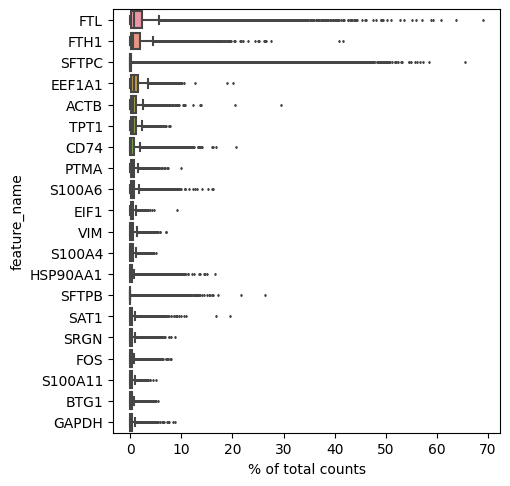

In [21]:
sc.pl.highest_expr_genes(lung_adata, n_top=20)

**Number of sequenced genes by assay**


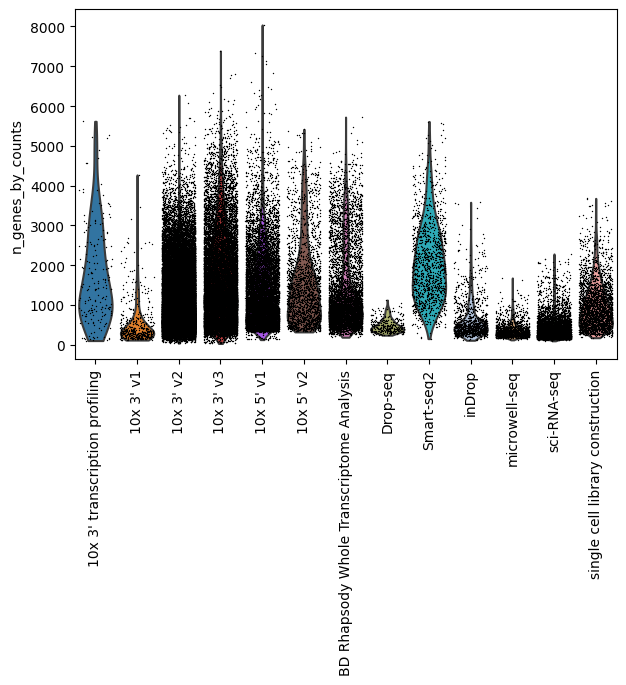

In [22]:
sc.pp.calculate_qc_metrics(lung_adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(lung_adata, "n_genes_by_counts", groupby="assay", jitter=0.4, rotation=90)

**Total counts by assay**


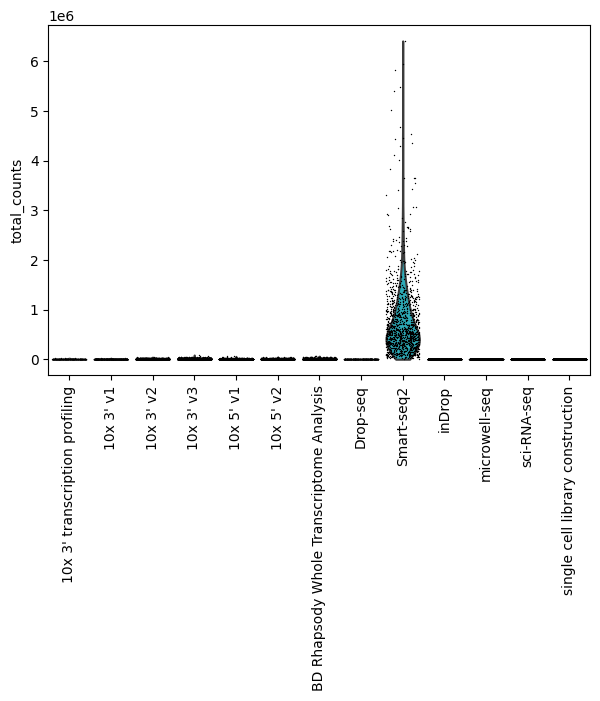

In [23]:
sc.pl.violin(lung_adata, "total_counts", groupby="assay", jitter=0.4, rotation=90)

You can see that Smart-Seq2 is an outlier for the total counts per cell, so let's exlcude it to see how the rest of the assays look like


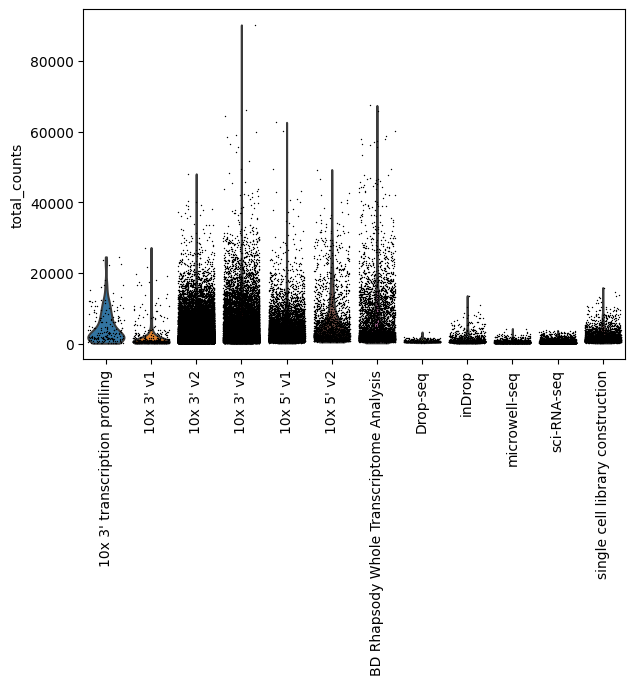

In [24]:
sc.pl.violin(
    lung_adata[lung_adata.obs["assay"] != "Smart-seq2",],
    "total_counts",
    groupby="assay",
    jitter=0.4,
    rotation=90,
)

### Quick normalization and embeddings

Let's perform a bread and butter normalization and take a look at UMAP embeddings, but for all the data below we'll exclude Smart-seq2 as this requires an extra step to normalize based on gene lengths


In [25]:
lung_adata = lung_adata[lung_adata.obs["assay"] != "Smart-seq2",].copy()
lung_adata.layers["counts"] = lung_adata.X

Now let's do some basic normalization:

- Normalize by sequencing depth
- Transform to log-scale
- Select 500 highly variable genes
- Scale values across the gene axis


In [26]:
sc.pp.normalize_total(lung_adata, target_sum=1e4)
sc.pp.log1p(lung_adata)
sc.pp.highly_variable_genes(lung_adata, n_top_genes=500, flavor="seurat_v3", layer="counts")
lung_adata = lung_adata[:, lung_adata.var.highly_variable]
sc.pp.scale(lung_adata, max_value=10)

/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


And reduce dimensionality by obtaining UMAP embeddings.


In [27]:
sc.tl.pca(lung_adata)
sc.pp.neighbors(lung_adata)
sc.tl.umap(lung_adata)

And plot these embeddings.


In [28]:
n_cell_types = len(lung_adata.obs["cell_type"].drop_duplicates())

from random import randint

colors = []

for i in range(len(lung_adata.obs["cell_type"].drop_duplicates())):
    colors.append("#%06X" % randint(0, 0xFFFFFF))

/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


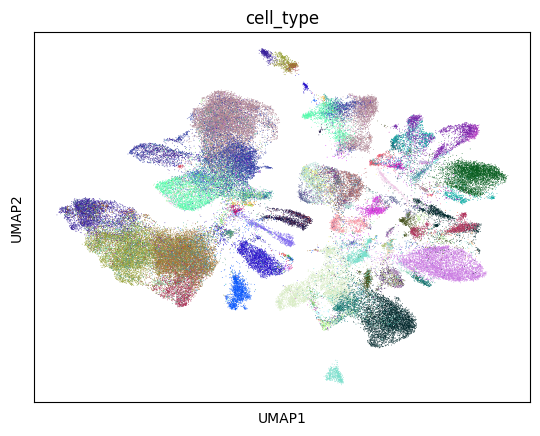

In [29]:
sc.pl.umap(lung_adata, color="cell_type", palette=colors, legend_loc=None)

Let's color by assay.


/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


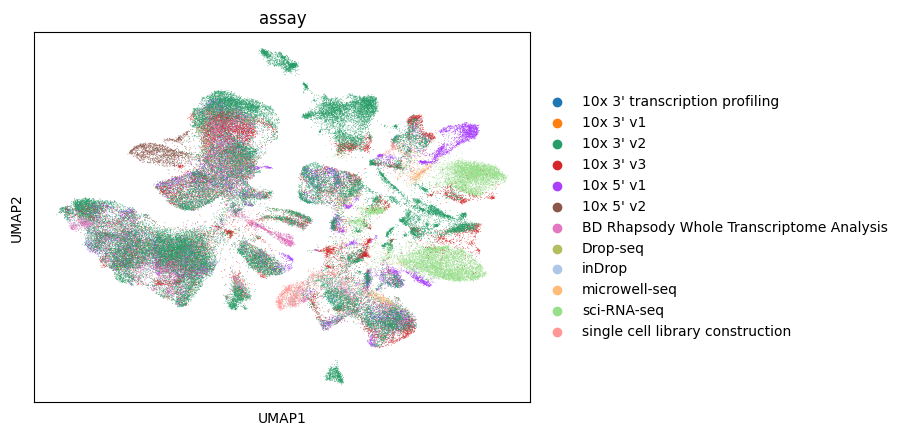

In [30]:
sc.pl.umap(lung_adata, color="assay")

Given the high number of cell types it makes it hard to visualize, so let's look at the top 20 most abundant cell types.


In [31]:
top_cell_types = lung_adata.obs["cell_type"].value_counts()
top_cell_types = list(top_cell_types.reset_index().head(20)["index"])

/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


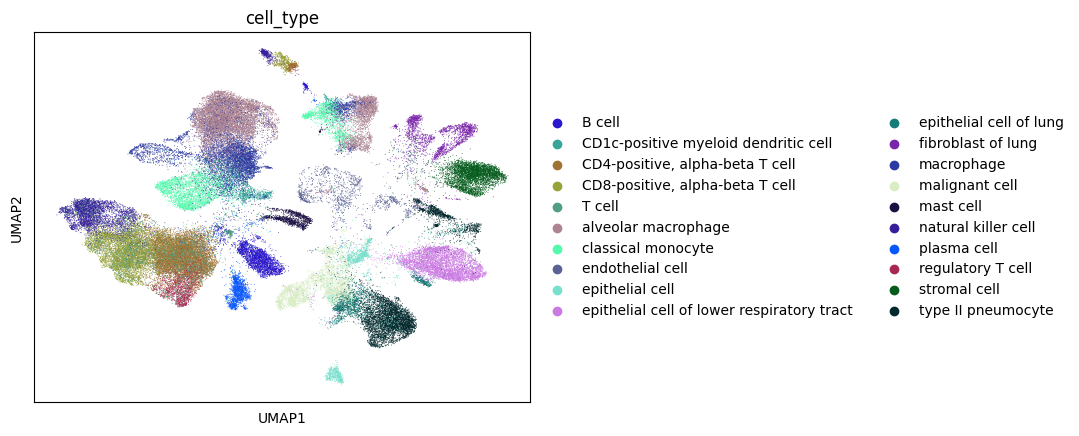

In [32]:
lung_adata_top_cell_types = lung_adata[[i in top_cell_types for i in lung_adata.obs["cell_type"]], :]
sc.pl.umap(lung_adata_top_cell_types, color="cell_type")

Let's color by assay of this subset of the data.


/home/bruce/cell-census/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


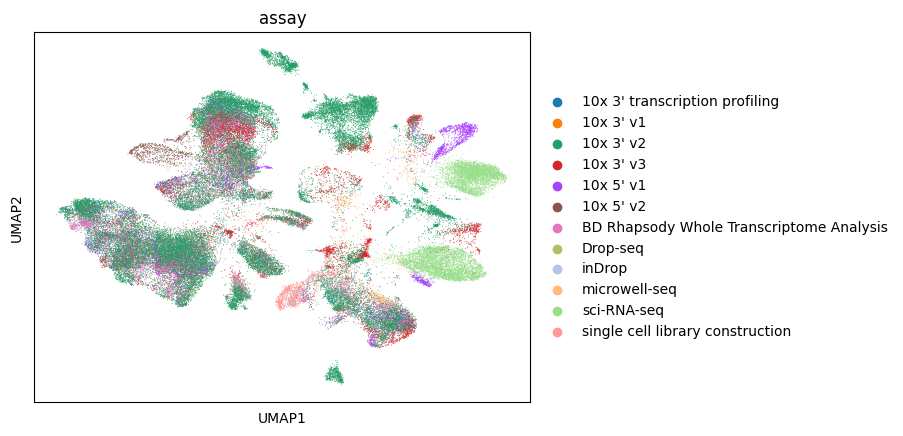

In [33]:
sc.pl.umap(lung_adata_top_cell_types, color="assay")